[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/docs/pinecone-quickstart.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/docs/pinecone-quickstart.ipynb)

# Pinecone quickstart

Pinecone provides long-term memory for high-performance AI applications. It's a managed, cloud-native vector database with a streamlined API and no infrastructure hassles. Pinecone serves fresh, relevant query results with low latency at the scale of billions of vectors.

This notebook shows you how to set up a Pinecone vector database in minutes using Python. To run through the process using TypeScript, Java, or curl instead, see the [Quickstart](https://docs.pinecone.io/guides/get-started/quickstart) in the Pinecone docs.

## Install dependencies

Pinecone exposes a simple [REST API](https://docs.pinecone.io/reference/api/introduction) for interacting with its vector database. You can use the API directly, or you can use one of the official [Pinecone clients](https://docs.pinecone.io/reference/pinecone-clients).

For this notebook, install the Python client and a library that makes it easy to sign up with Pinecone:

In [1]:
!pip install -qU pinecone-client==4.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.5/215.5 kB 3.3 MB/s eta 0:00:00


## Sign up or log in

Sign up for a [free Pinecone account](https://www.pinecone.io/pricing/) and get an API key. Put your key in `PINECONE_API_KEY` below when initializing a new client instance:


In [2]:
from pinecone import Pinecone, ServerlessSpec
import os
import time

api_key = os.environ.get('PINECONE_API_KEY')
pc = Pinecone(api_key=api_key)

Now we setup our index specification, this allows us to define the cloud provider and region where we want to deploy our index.

In [3]:
from pinecone import ServerlessSpec

cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

## Create a serverless index

In Pinecone, an [index](https://docs.pinecone.io/guides/indexes/understanding-indexes) is the highest-level organizational unit of data, where you define the dimension of vectors to be stored and the [similarity metric](https://www.pinecone.io/learn/vector-similarity/) to be used when querying them. Normally, you choose a dimension and similarity metric based on the [embedding model](https://www.pinecone.io/models/) used to create your vectors. For this quickstart, however, you'll use a configuration that makes it easy to verify your query results.

[Create a serverless index](https://docs.pinecone.io/guides/indexes/create-an-index#create-a-serverless-index) named `docs-quickstart-notebook` that stores vectors of 2 dimensions and performs nearest-neighbor search using the cosine similarity metric:

In [4]:
index_name = "docs-quickstart-notebook"

In [5]:
import time

if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=2,
        metric="cosine",
        spec=spec
    )
    # wait for index to be ready
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

## Upsert vectors

Within an index, vectors are stored in [namespaces](https://docs.pinecone.io/guides/indexes/use-namespaces), and all upserts, queries, and other data operations always target one namespace:

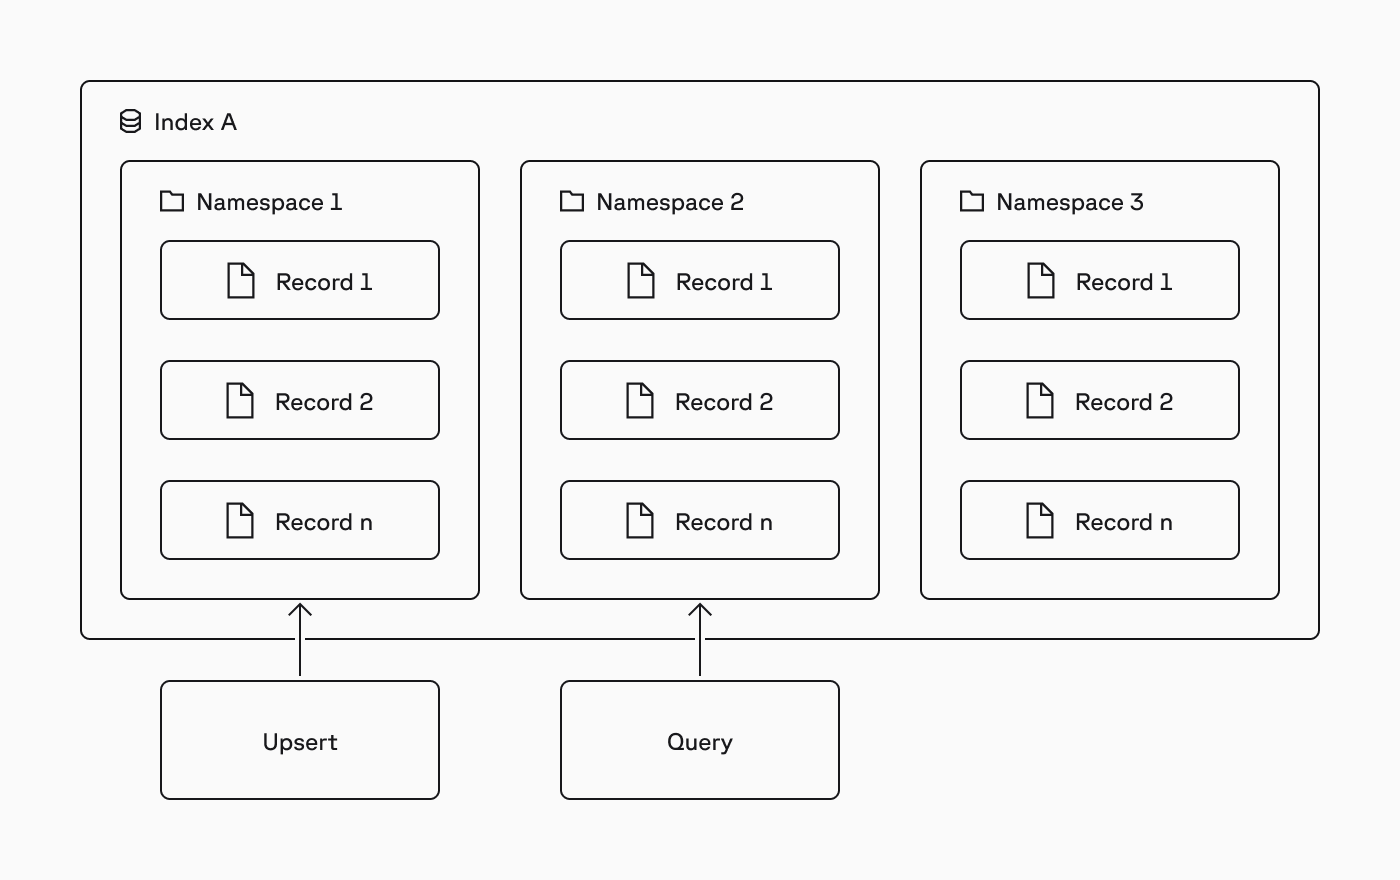

Now that you've created your index, target the `docs-quickstart-notebook` index and use the [`upsert`](https://docs.pinecone.io/reference/api/data-plane/upsert) operation to write six 2-dimensional vectors into 2 distinct namespaces:

In [6]:
index = pc.Index(index_name)
time.sleep(1)

upsert1 = index.upsert(
    vectors=[
        {"id": "vec1", "values": [1.0, 1.5]},
        {"id": "vec2", "values": [2.0, 1.0]},
        {"id": "vec3", "values": [0.1, 3.0]},
    ],
    namespace="ns1"
)

print(upsert1)

upsert2 = index.upsert(
    vectors=[
        {"id": "vec1", "values": [1.0, -2.5]},
        {"id": "vec2", "values": [3.0, -2.0]},
        {"id": "vec3", "values": [0.5, -1.5]},
    ],
    namespace="ns2"
)

print(upsert2)

{'upserted_count': 3}
{'upserted_count': 3}


**Note:** When upserting larger amounts of data, [upsert data in batches](https://docs.pinecone.io/guides/data/upsert-data#upsert-records-in-batches) of 100-500 vectors over multiple upsert requests.

## Check the index

Pinecone is eventually consistent, so there can be a delay before your upserted vectors are available to query. Use the `describe_index_stats` operation to check if the current vector count matches the number of vectors you upserted:

In [7]:
print(index.describe_index_stats())

{'dimension': 2,
 'index_fullness': 0.0,
 'namespaces': {'ns2': {'vector_count': 3}},
 'total_vector_count': 3}


## Run a similarity search

Query each namespace in your index for the 3 vectors that are most similar to an example 2-dimensional vector using the cosine distance metric you specified for the index:

In [8]:
query_results1 = index.query(
    namespace="ns1",
    vector=[1.0, 1.5],
    top_k=3,
    include_values=True
)

print(query_results1)

query_results2 = index.query(
    namespace="ns2",
    vector=[1.0,-2.5],
    top_k=3,
    include_values=True
)

print(query_results2)

{'matches': [{'id': 'vec1', 'score': 1.0, 'values': [1.0, 1.5]},
             {'id': 'vec2', 'score': 0.868243158, 'values': [2.0, 1.0]},
             {'id': 'vec3', 'score': 0.850068152, 'values': [0.1, 3.0]}],
 'namespace': 'ns1',
 'usage': {'read_units': 6}}
{'matches': [{'id': 'vec1', 'score': 1.0, 'values': [1.0, -2.5]},
             {'id': 'vec3', 'score': 0.998274386, 'values': [0.5, -1.5]},
             {'id': 'vec2', 'score': 0.824041963, 'values': [3.0, -2.0]}],
 'namespace': 'ns2',
 'usage': {'read_units': 6}}


<details>
  <summary>Query results explained</summary>

  Your index uses the cosine distance metric, which measures similarity based on the angle between two vectors. Scores range between 1 and -1. The greater the score, the greater the similarity between the vectors.

  In the following graph, the upper and lower right quadrants show the query results from namespaces `ns1` and `ns2`, respectively. In each quadrant, blue represents the most similar vector, green the second most similar, and red the third most similar. In this case, the most similar vectors are identical to the query vectors, with a score of 1, and so the blue arrows represent both the query vectors and the nearest vectors.
  
  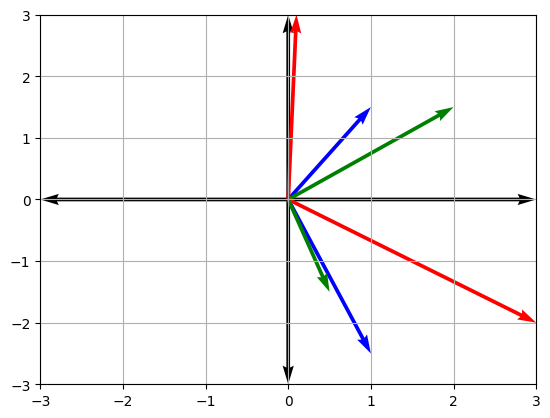
</details>

This is a simple example. As you put more demands on Pinecone, you’ll see it returning low-latency, accurate results at huge scales, with indexes of up to billions of vectors.

## Clean up

When you no longer need the “docs-quickstart-notebook” index, use the [`delete_index`](https://docs.pinecone.io/reference/api/control-plane/delete_index) operation to delete it:

In [9]:
pc.delete_index(index_name)

After you delete an index, you cannot use it again or recover it.